In [19]:
from comet_ml import Experiment

In [20]:
from dotenv import load_dotenv
load_dotenv(r'.env')
import os
comet_api_key = os.environ.get('COMET_API_KEY')

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
from plots import * # tous les plus utilisés
import pickle

## Modèles de base (15%)

In [22]:
df = pd.read_csv('data/nhl_train_data.csv')

### 1. Régression logistique

In [26]:
experience_comet = False

Précision du modèle : 0.91
Accuracy pour la classe 0 : 1.0
Accuracy pour la classe 1 : 0.0


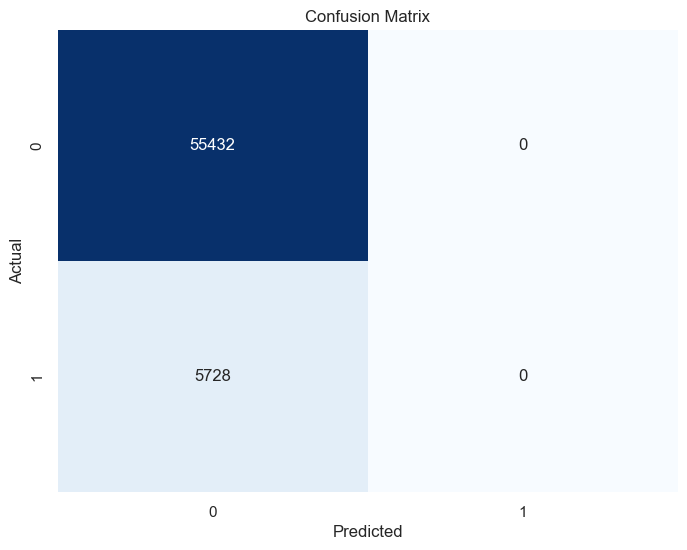

In [27]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features with best hyperparameters")

# Sélection de la caractéristique de distance comme variable indépendante (X) et la cible (isGoal) comme variable dépendante (y)
X = df[['distanceToNet']]
y = df['isGoal']

# Division des données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement d'un classifieur de regressiom logistique
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred = clf.predict(X_valid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)
#print(f"Confusion Matrix:\n{conf_matrix}")
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Calcul de l'accuracy du modèle
accuracy = accuracy_score(y_valid, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

# Calcul des accuracies par classe
accuracy_class_0 = (y_pred[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1 = (y_pred[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

# Affichage des résultats
print(f"Accuracy pour la classe 0 : {accuracy_class_0}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1}")

if experience_comet : 

    pickle.dump(clf, open("models/reg_logistic_distance.json", "wb"))

    experience.log_model("Regression_logistique", "models/reg_logistic_distance.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="Regression logistique sur Distance Confusion Matrix")
    experience.log_metric("accuracy", accuracy)
    experience.add_tag("Reg_logist")

    experience.end()

Il y a un réel problème de prédiction pour les buts. Il s'agit d'une classe foretement minoritaire par rapport à la classe de non buts. On le voit bien ici puisqu'aucun des 5728 buts n'ai prédit.

### Figures

#### i) ROC/AUC

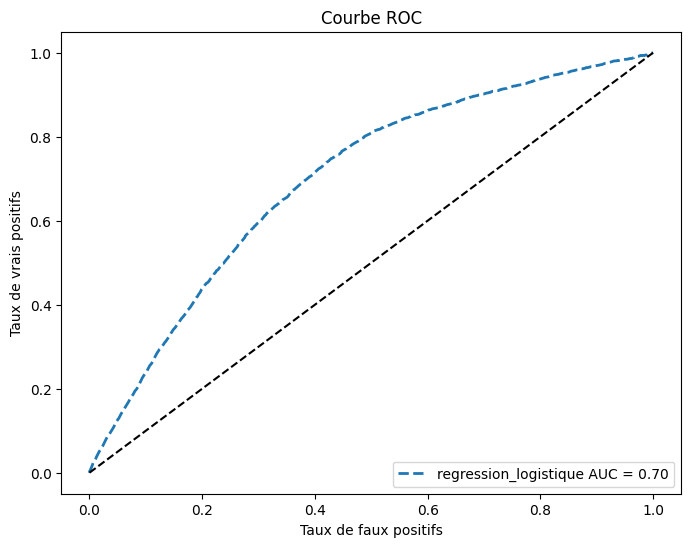

In [6]:
plot_roc_auc([clf], [X_valid], [y_valid], ["regression_logistique"])

#### ii) Taux de buts vs percentile de probabilité

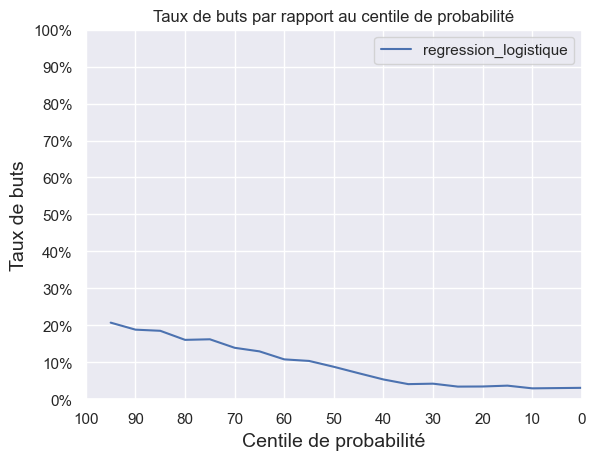

In [7]:
plot_taux_buts_par_centile([clf], [X_valid], [y_valid], ["regression_logistique"])

In [8]:
#def plot_goal_rate_vs_percentile(y_prob, y_valid):
#    """
#    Cette fonction trace la courbe du taux de buts en fonction du centile de probabilité du modèle.
#    params:  y_prob, y_valid
#    return:  fig_goal_rate
#    """
#    # Convertir les probabilités en une série 1D
#    y_series = np.array(y_valid)
#    y_series = np.reshape(y_series, (y_series.shape[0]))
#
#    # Créer un DataFrame avec les probabilités et les étiquettes réelles
#    prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_series})
#
#    # Trier le DataFrame par ordre croissant des probabilités
#    prob_df = prob_df.sort_values(by='Probabilite')
#
#    # Ajouter une colonne 'Centile' au DataFrame
#    prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)
#
#    # Calculer le taux de buts pour chaque centile
#    goal_rate_by_centile = prob_df.groupby('Centile')['isGoal'].mean()
#
#    # Convertir l'index en pourcentage pour représenter le centile
#    percentiles = goal_rate_by_centile.index.codes / len(goal_rate_by_centile.index.categories) * 100
#
#    # Tracer le taux de buts en fonction du centile
#    fig_goal_rate = plt.figure(figsize=(10, 6))
#    plt.plot(percentiles, goal_rate_by_centile.values, label='model')
#    plt.xlabel('Centile de probabilité', fontsize=14)
#    plt.ylabel('Taux de buts', fontsize=14)
#    plt.title("Taux de buts en fonction du centile de probabilité")
#    plt.show()
#    return fig_goal_rate
#
## Utilisation de la fonction avec vos données
#y_prob = clf.predict_proba(X_valid)[:, 1]
#fig_goal_rate = plot_goal_rate_vs_percentile(y_prob, y_valid)
#plt.show()


#### iii) Proportion cumulée de buts vs percentile de probabilité

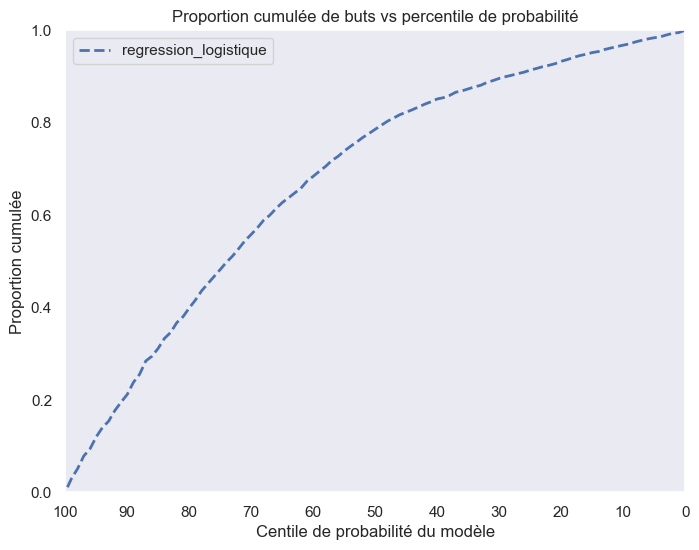

In [9]:
cumulative_goal_rate([clf], [X_valid], [y_valid], ["regression_logistique"])

In [10]:
## Calcul des probabilités prédites
#y_prob = clf.predict_proba(X_valid)[:, 1]
#
## Création du DataFrame avec probabilités et étiquettes réelles
#prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_valid})
#
## Tri du DataFrame par ordre croissant des probabilités
#prob_df = prob_df.sort_values(by='Probabilite')
#
## Ajout de la colonne 'Centile' au DataFrame
#prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)
#
## Calcul du nombre cumulatif de buts et non-buts pour chaque centile
#cumulative_goals = prob_df.groupby('Centile')['isGoal'].cumsum()
#cumulative_shots = prob_df.groupby('Centile').cumcount() + 1
#
## Calcul de la proportion cumulée de buts et non-buts pour chaque centile
#cumulative_goal_proportion = cumulative_goals / cumulative_shots
#cumulative_non_goal_proportion = 1 - cumulative_goal_proportion
#
#
#resampled_cumulative_goal_proportion = np.interp(percentiles, np.linspace(0, 100, len(cumulative_goal_proportion.values)), cumulative_goal_proportion.values)
#
#plt.figure(figsize=(10, 6))
#plt.plot(percentiles, resampled_cumulative_goal_proportion, label='Buts', linestyle='--')
#plt.xlabel('Centile de probabilité')
#plt.ylabel('Proportion cumulée de buts')
#plt.title('Proportion cumulée de buts en fonction du centile de probabilité')
#plt.show()



#### iv) Courbe de fiabilité

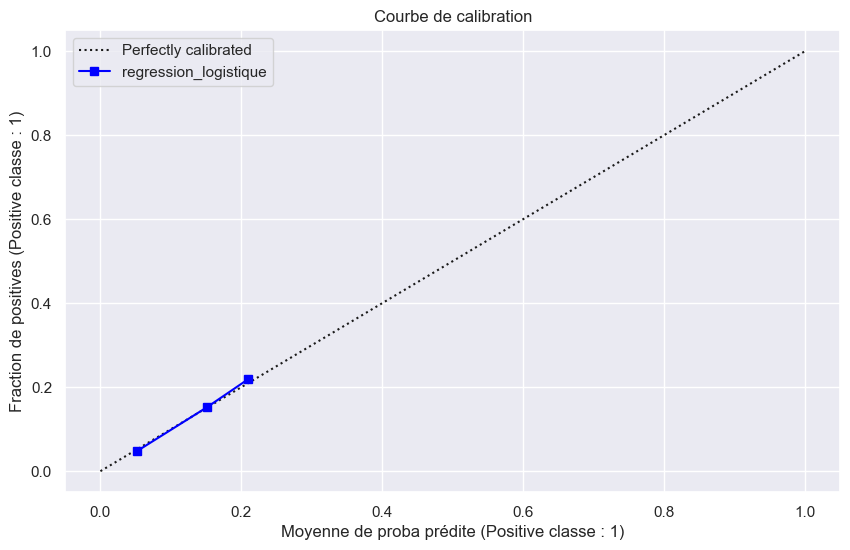

In [11]:
plot_calibration_curve([clf], [X_valid], [y_valid], ['regression_logistique'])

### 2. Régressions logistiques sur la caractéristique d'angle, de distance, puis à la fois sur les caractéristiques de distance et d’angle

In [12]:
df = pd.read_csv('data/nhl_train_data.csv')

In [ ]:
experience_comet = False

In [ ]:
if experience_comet:
    exp_distance = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02')
    exp_distance.set_name("Modèle Regression logistique - Distance")

# Diviser les données en ensembles d'entraînement et de validation
X_distance = df[['distanceToNet']]
y = df['isGoal']

X_train_distance, X_valid_distance, y_train, y_valid = train_test_split(X_distance, y, test_size=0.2, random_state=42)

# Entraîner le modèle
clf_distance = LogisticRegression()
clf_distance.fit(X_train_distance, y_train)

# Prédiction 
y_distance = clf_distance.predict(X_valid_distance)

# Prédiction probabilité
y_prob_distance = clf_distance.predict_proba(X_valid_distance)[:, 1]

# Calcul des métriques du modèle
accuracy_distance = accuracy_score(y_valid, y_distance)
conf_matrix_distance = confusion_matrix(y_valid, y_distance)
fpr_distance, tpr_distance, thresholds_distance = roc_curve(y_valid, y_prob_distance)
auc_distance = roc_auc_score(y_valid, y_prob_distance)

print(f"Précision du modèle (distance) : {accuracy_distance:.2f}")

if experience_comet:
    # Log des métriques et informations dans Comet ML pour clf_distance
    exp_distance.log_model("Modèle Logistic Regression - Distance", "models/logistic_distance.pkl")
    exp_distance.log_confusion_matrix(y_true=y_valid, y_predicted=y_distance, title="Matrice de confusion - Distance")
    exp_distance.log_curve("Courbe ROC - Distance", fpr_distance, tpr_distance)
    exp_distance.log_metric("accuracy - Distance", accuracy_distance)
    exp_distance.log_metric("AUC - Distance", auc_distance)
    exp_distance.add_tag("reg_logist")

    # Sauvegarde du modèle clf_distance
    with open("models/logistic_distance.pkl", "wb") as f:
        pickle.dump(clf_distance, f)
    exp_distance.end()

In [ ]:
if experience_comet:
    exp_angle = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02')
    exp_angle.set_name("Modèle Regression logistique - Angle")

# Diviser les données en ensembles d'entraînement et de validation
X_angle = df[['relativeAngleToNet']]
X_train_angle, X_valid_angle, _, _ = train_test_split(X_angle, y, test_size=0.2, random_state=42)
#y = df['isGoal']

# Entraîner le modèle
clf_angle = LogisticRegression()
clf_angle.fit(X_train_angle, y_train)

# Prédictions
y_angle = clf_angle.predict(X_valid_angle)

# Prédiction probabilité
y_prob_angle = clf_angle.predict_proba(X_valid_angle)[:, 1]

# Calcul des métriques du modèle
accuracy_angle = accuracy_score(y_valid, y_angle)
conf_matrix_angle = confusion_matrix(y_valid, y_angle)
fpr_angle, tpr_angle, thresholds_angle = roc_curve(y_valid, y_prob_angle)
auc_angle = roc_auc_score(y_valid, y_prob_angle)

print(f"Précision du modèle (angle): {accuracy_angle:.2f}")

if experience_comet:
    # Log des métriques et informations dans Comet ML pour clf_angle
    exp_angle.log_model("Modèle Logistic Regression - Angle", "models/logistic_angle.pkl")
    exp_angle.log_confusion_matrix(y_true=y_valid, y_predicted=y_angle, title="Matrice de confusion - Angle")
    exp_angle.log_curve("Courbe ROC - Angle", fpr_angle, tpr_angle)
    exp_angle.log_metric("accuracy - Angle", accuracy_angle)
    exp_angle.log_metric("AUC - Angle", auc_angle)
    exp_angle.add_tag("reg_logist")

    # Sauvegarde du modèle clf_angle
    with open("models/logistic_angle.pkl", "wb") as f:
        pickle.dump(clf_angle, f)
    exp_angle.end()


In [ ]:
if experience_comet:
    exp_distance_angle = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02')
    exp_distance_angle.set_name("Modèle Regression logistique - Distance et Angle")

# Diviser les données en ensembles d'entraînement et de validation
X_distance_angle = df[['distanceToNet', 'relativeAngleToNet']]
#y = df['isGoal']
X_train_distance_angle, X_valid_distance_angle, _, _ = train_test_split(X_distance_angle, y, test_size=0.2, random_state=42)

# Entraîner le modèle
clf_distance_angle = LogisticRegression()
clf_distance_angle.fit(X_train_distance_angle, y_train)

# Prédiction
y_distance_angle = clf_distance_angle.predict(X_valid_distance_angle)

# Prédiction probabilité
y_prob_distance_angle = clf_distance_angle.predict_proba(X_valid_distance_angle)[:, 1]

# Calcul des métriques du modèle
accuracy_distance_angle = accuracy_score(y_valid, y_distance_angle)
conf_matrix_distance_angle = confusion_matrix(y_valid, y_distance_angle)
fpr_distance_angle, tpr_distance_angle, thresholds_distance_angle = roc_curve(y_valid, y_prob_distance_angle)
auc_distance_angle = roc_auc_score(y_valid, y_prob_distance_angle)

print(f"Précision du modèle (distance et angle): {accuracy_distance_angle:.2f}")

if experience_comet:
    # Log des métriques et informations dans Comet ML pour clf_distance_angle
    exp_distance_angle.log_model("Modèle Logistic Regression - Distance et Angle", "models/logistic_distance_angle.pkl")
    exp_distance_angle.log_confusion_matrix(y_true=y_valid, y_predicted=y_distance_angle, title="Matrice de confusion - Distance et Angle")
    exp_distance_angle.log_curve("Courbe ROC - Distance et Angle", fpr_distance_angle, tpr_distance_angle)
    exp_distance_angle.log_metric("accuracy - Distance et Angle", accuracy_distance_angle)
    exp_distance_angle.log_metric("AUC - Distance et Angle", auc_distance_angle)
    exp_distance_angle.add_tag("reg_logist")

    # Sauvegarde du modèle clf_distance_angle
    with open("models/logistic_distance_angle.pkl", "wb") as f:
        pickle.dump(clf_distance_angle, f)
    exp_distance_angle.end()

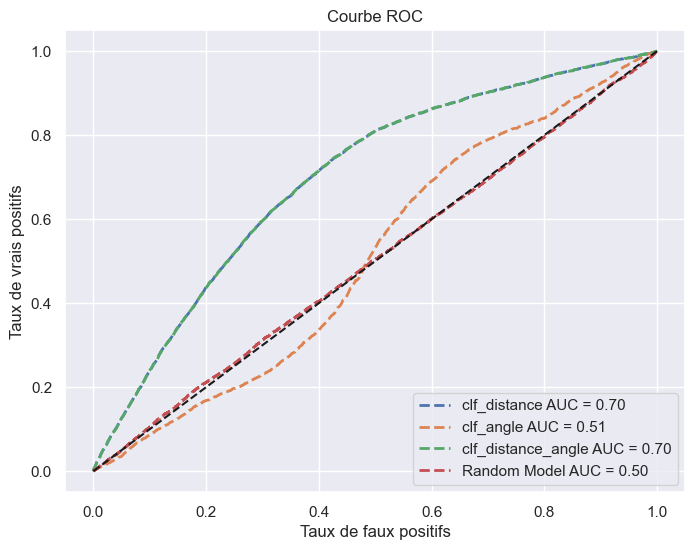

In [14]:
models = [clf_distance, clf_angle, clf_distance_angle, None]
X_list = [X_valid_distance, X_valid_angle, X_valid_distance_angle, None]
y_list = [y_valid, y_valid, y_valid, None]
nom_models = ['clf_distance', 'clf_angle', 'clf_distance_angle', 'Random Model']

plot_roc_auc(models, X_list, y_list, nom_models)

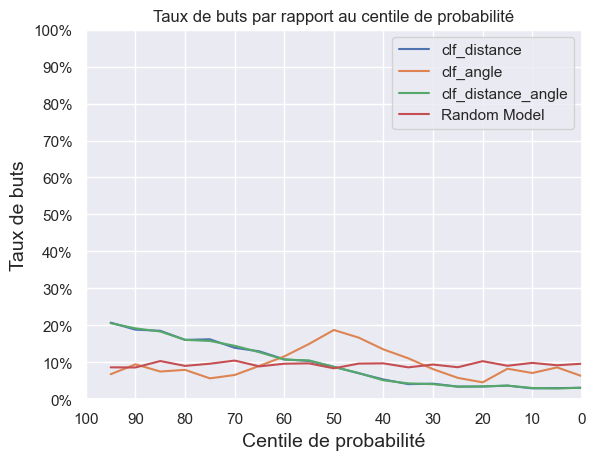

In [15]:
plot_taux_buts_par_centile(models, X_list, y_list, nom_models)

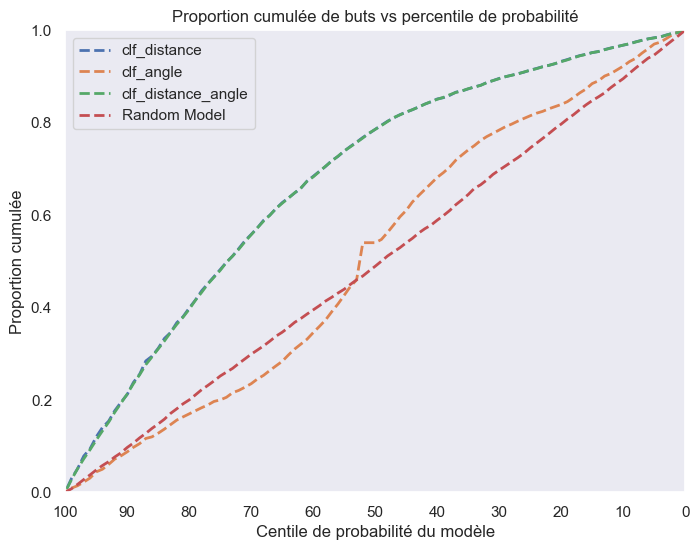

In [16]:
cumulative_goal_rate(models, X_list, y_list, nom_models)

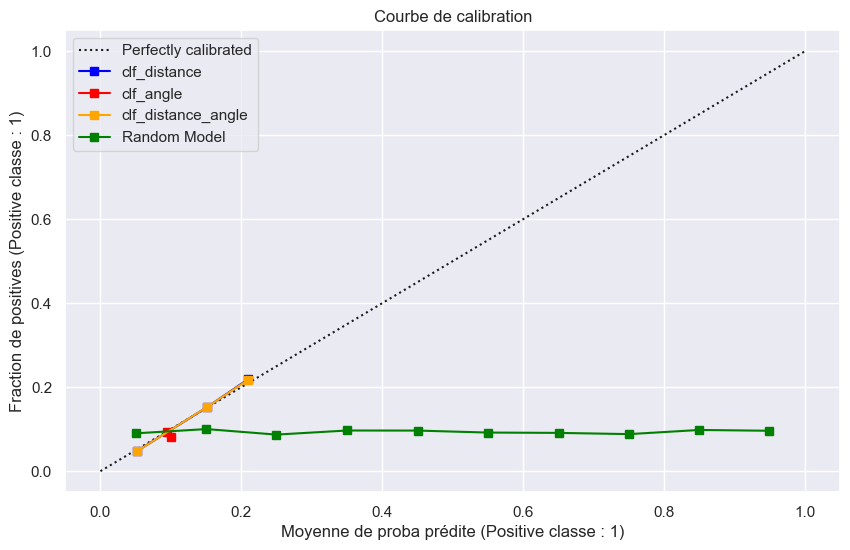

In [17]:
plot_calibration_curve(models, X_list, y_list, nom_models)